In [2]:
import torch
from torch import nn
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from smokingml.datasets.nursing_dataset_v1 import WINSIZE, NursingDatasetV1, nursingv1_train_dev_test_split
from smokingml.datasets.nursing_dataset_v1.dataloading import load_one_session, load_one_windowed_session
from smokingml.datasets.nursing_dataset_v1.utils import window_session, train_test_split_windows, get_all_session_ids
from smokingml.modules import train_loop, optimization_loop, evaluate_loop
from smokingml.models import ResNetConv, ResNetClassifier, ResNetLSTM, MLP_1hl
from smokingml.utils import plot_and_save_cm, Colors, prepare_labels_for_plot
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [3]:
data_dir = Path('../data/nursingv1_dataset/')
device = 'cuda:0'

# 1st LSTM: One Sequence of Points
- entire session is sequence of inputs
- each input is one data point (xyz)
- input shape to model is ($L$,$H_{in}$)

$L =$ `len(session)`

$H_{in} = 3$

In [13]:
class LSTM1(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(input_size=3, hidden_size=64, bias=False)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        # x is len(session) x 3
        o, (h,c) = self.lstm(x) # o is shape (len(session), 64)
        o = nn.functional.relu(o[-1])
        logits = self.mlp(o)

        return logits

model = LSTM1().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
X,_ = load_one_session(data_dir, 0) 

# logits is the classification for the final point in X
logits = model(X.to(device).float())

# 2nd LSTM: Many sequences of points
- session is padded and windowed into `len(session)` windows
- each window is shaped into sequence of 101 3D inputs (xyz)
- input to LSTM is ($N$, $L$,$H_{in}$)

$N = 64$

$L = 101$

$H_{in} = 3$

In [3]:
class LSTM2(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(input_size=3, hidden_size=64, bias=False, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        # x is batch_size x 303, want shape: batch_size x 101 x 3
        x = torch.cat(x.unsqueeze(2).split(WINSIZE, dim=1), axis=2)
        o, (h,c) = self.lstm(x) # o is shape (batch_size, winsize, 64)
        o = nn.functional.relu(o[:,-1,:])
        logits = self.mlp(o)

        return logits

model = LSTM2().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [4]:
ids = get_all_session_ids(data_dir)[:10]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(data_dir, 0.8, 0.2, 0, WINSIZE, True, ids)

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
devloader = DataLoader(dev_dataset, shuffle=True, batch_size=64)

optimization_loop(model, trainloader, devloader, criterion, optimizer, 40, device)

Starting optimization_loop


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.0044834: Dev Loss: 0.24951:  98%|█████████▊| 39/40 [05:51<00:09,  9.52s/it]

# 3rd LSTM: Many Sequences of Windows
- session is padded and windowed into `len(session)` windows
- each window is sequence of 303 inputs (flattened xyz)
- input to model is $(N,L, H_{in})$, $N=64$, $L=303$, $H_{in}=1$
- in model, each window is padded and windowed into 303 subwindows of length 15 (shape 303x15) before theyre fed to lstm
    - in window, first 101 are x, next 101 are y, etc.
    - in subwindows, first 5 are x, next 5 are z, etc.
- input to LSTM is ($N$, $L$, $H_{in}$)

$N = 64$

$L = 303$

$H_{in} = 15$

In [3]:
class LSTM3(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(input_size=15, hidden_size=64, bias=False, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )
    
    def window_window(self, x, subwinsize):

        # Seperate x,y,z
        x = x.reshape(-1, 3, WINSIZE)

        # Pad x,y, and z on both sides with 0s
        x = nn.functional.pad(x, (subwinsize//2, subwinsize//2), 'constant', 0)

        # Window x,y, and z
        xacc = x[:,0].unsqueeze(2)
        yacc = x[:,1].unsqueeze(2)
        zacc = x[:,2].unsqueeze(2)

        w = subwinsize - 1
        xs = [xacc[:, :-w]]
        ys = [yacc[:, :-w]]
        zs = [zacc[:, :-w]]

        for i in range(1,w):
            xs.append(xacc[:, i:i-w])
            ys.append(yacc[:, i:i-w])
            zs.append(zacc[:, i:i-w])
        
        xs.append(xacc[:, w:])
        ys.append(yacc[:, w:])
        zs.append(zacc[:, w:])

        xs = torch.cat(xs, dim=2)
        ys = torch.cat(ys, dim=2)
        zs = torch.cat(zs, dim=2)

        # Re-combine each window of xyz
        return torch.cat([xs, ys, zs], dim=2)

    def forward(self, x):
        # x is batch_size x 303, want shape: batch_size x 101 x 15
        x = self.window_window(x, subwinsize=5)
        
        o, (h,c) = self.lstm(x) # o is shape (batch_size, winsize, 64)
        o = nn.functional.relu(o[:,-1,:])
        logits = self.mlp(o)

        return logits

model = LSTM3().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
ids = get_all_session_ids(data_dir)[:8]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(data_dir, 0.8, 0.2, 0, WINSIZE, True, ids)

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
devloader = DataLoader(dev_dataset, shuffle=True, batch_size=64)

optimization_loop(model, trainloader, devloader, criterion, optimizer, 20, device, Path('lstm/del'))

# 4th LSTM: CNN -> LSTM
- input window to model of shape batch_size x 303
- model reshapes input to batch_size x 3 x 101 (three channels)
- uses CNN layer with 5 filters and padding to get output shape batch_size x 5 x 101
- input shape to CNN is $(N,C_{in},L_{in})$ and output shape is $(N,C_{out},L_{out})$, where:

$N=64$,  $C_{in}=3$, $L_{in}=101$, $C_{out}=5$, $L_{in}=101$

- This is reshaped to batch_size x 101 x 15 (transpose) and given to LSTM
- input to LSTM is $(N,L,H_{in})$, where:

$N=64$, $L=101$, $H_{in}=5$

- output of LSTM with 64 hidden states is batch_size x 101 x 64
- the final hidden state (shape batch_size x 64) is given to MLP to get one output

In [67]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv1d(in_channels=3, out_channels=5, kernel_size=8, padding='same')
        self.l1 = nn.LSTM(input_size=5, hidden_size=64, bias=False, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )
    
    def forward(self, x):
        # x is batch_size x 303, want shape: batch_size x 3 x 101
        x = x.view(-1, 3, WINSIZE)

        x = self.c1(x)
        x = torch.transpose(x, 1, 2)
        o, (h,c) = self.l1(x)
        o = nn.functional.relu(o[:,-1,:])
        logits = self.mlp(o)

        return logits

model = CNN_LSTM().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [69]:
ids = get_all_session_ids(data_dir)[:15]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(data_dir, 0.8, 0.2, 0, True, ids)

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
devloader = DataLoader(dev_dataset, shuffle=True, batch_size=64)

optimization_loop(model, trainloader, devloader, criterion, optimizer, 30, device)

Starting optimization_loop


Epoch 29: Train Loss: 0.0097216: Dev Loss: 0.23149: 100%|██████████| 30/30 [08:10<00:00, 16.36s/it]

Finished optimization_loop. Elapsed time: 490.719


# 5th LSTM - ResNet

In [79]:
class ResNetLSTM(nn.Module):
    def __init__(self, winsize: int):
        super().__init__()
        self.winsize = winsize

        out_channels = 5
        self.resnet = ResNetMod(in_channels=3, out_channels=out_channels, winsize=self.winsize)
        
        hidden_size = 4
        self.l1 = nn.LSTM(input_size=out_channels, hidden_size=hidden_size, bias=False, batch_first=True)
        
        nhl = 128
        self.mlp = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=nhl),
            nn.Dropout(p=0.05),
            nn.ReLU(),
            nn.Linear(in_features=nhl, out_features=1)
        )
    
    def forward(self, x):
        # x is batch_size x 303, want shape: batch_size x 3 x 101
        x = x.view(-1, 3, self.winsize)

        x = self.resnet(x)

        x = torch.transpose(x, 1, 2)
        o, (h,c) = self.l1(x)
        o = o[:,-1,:]

        logits = self.mlp(o)

        return logits

    @staticmethod
    def get_criterion():
        return nn.BCEWithLogitsLoss()

    @staticmethod
    def get_optimizer(model):
        return torch.optim.Adam(model.parameters(), lr=3e-4)

class ResNetMod(nn.Module):
    def conv_block(self, in_channels, out_channels, kernel_size, use_relu=True):
        conv_block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.Dropout(p=0.8),
            nn.BatchNorm1d(num_features=out_channels),
        )
        if use_relu:
                conv_block.append(nn.ReLU())

        return conv_block

    def inner_res_block(self, in_channels, out_channels):
        return nn.Sequential(
            self.conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=8),
            self.conv_block(in_channels=out_channels, out_channels=out_channels, kernel_size=5),
            self.conv_block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, use_relu=False)
        )
    
    def shortcut(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm1d(num_features=out_channels)
        )

    def __init__(self, in_channels, out_channels, winsize):
        super().__init__()
        self.winsize = winsize
        self.out_channels = out_channels
        nfilters = (16, 32, self.out_channels)

        # First ResNet Block components
        self.shortcut1 = self.shortcut(in_channels=in_channels, out_channels=nfilters[0])
        self.res1 = self.inner_res_block(in_channels=in_channels, out_channels=nfilters[0])
        self.relu1 = nn.ReLU()

        # Second Res Block components
        self.shortcut2 = self.shortcut(in_channels=nfilters[0], out_channels=nfilters[1])
        self.res2 = self.inner_res_block(in_channels=nfilters[0], out_channels=nfilters[1])
        self.relu2 = nn.ReLU()

        # Third Res Block components
        self.shortcut3 = self.shortcut(in_channels=nfilters[1], out_channels=nfilters[2])
        self.res3 = self.inner_res_block(in_channels=nfilters[1], out_channels=nfilters[2])
        self.relu3 = nn.ReLU()

    def forward(self, x):
        # Reshape x: (batch_size, 303) -> (batch_size, 3, 101)
        x = x.view(-1, 3, self.winsize)
        
        # First Res Block
        x_shortcut = self.shortcut1(x)
        h = self.res1(x)
        y = h + x_shortcut
        y = self.relu1(y)

        # Second Res Block
        y_shortcut = self.shortcut2(y)
        h = self.res2(y)
        y = h + y_shortcut
        y = self.relu2(y)

        # Third Res Block
        y_shortcut = self.shortcut3(y)
        h = self.res3(y)
        y = h + y_shortcut
        y = self.relu3(y)

        return y

In [80]:
# trainloader = DataLoader(load_one_windowed_session(data_dir, 0), shuffle=True, batch_size=64)
# devloader = DataLoader(load_one_windowed_session(data_dir, 1), shuffle=True, batch_size=64)
torch.manual_seed(0)

ids = get_all_session_ids(data_dir)[:20]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(
    dir=data_dir, 
    train_size=0.7, 
    dev_size=0.3, 
    test_size=0, 
    winsize=WINSIZE, 
    shuffle=False, 
    session_ids=ids
)
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
devloader = DataLoader(dev_dataset, shuffle=True, batch_size=64)

print(train_dataset.session_ids)
print(dev_dataset.session_ids)

model = ResNetLSTM(winsize=WINSIZE).to(device)
criterion = ResNetLSTM.get_criterion()
optimizer = ResNetLSTM.get_optimizer(model)

fn = 'lstm/7'
optimization_loop(
    model, 
    trainloader, 
    devloader, 
    criterion, 
    optimizer, 
    40, 
    device,
    Path(f'../nursingv1_projects/tests/{fn}')
)

y_true, y_pred, trainloss, prec, recall, f1score = evaluate_loop(
    model=model, 
    criterion=criterion, 
    devloader=trainloader, 
    device=device, 
    outdir=Path(f'../nursingv1_projects/tests/{fn}/traincm.jpg'),
    metrics=True
)
print(f'{Colors.OKGREEN}Train: loss: {trainloss: .5f}, precision: {prec: .5f}, recall: {recall: .5f}, f1 score: {f1score: .5f}{Colors.ENDC}')

y_true, y_pred, devloss, prec, recall, f1score = evaluate_loop(
    model=model, 
    criterion=criterion, 
    devloader=devloader, 
    device=device,
    outdir=Path(f'../nursingv1_projects/tests/{fn}/devcm.jpg'),
    metrics=True
)
print(f'{Colors.OKGREEN}Dev: loss: {devloss: .5f}, precision: {prec: .5f}, recall: {recall: .5f}, f1 score: {f1score: .5f}{Colors.ENDC}')

[66 57 41 27 31 60  8 36 23 53 59 29 42 58]
[35 22 37 69 44 65]
Starting optimization_loop


Epoch 39: Train Loss: 0.03154: Dev Loss: 0.12051: 100%|██████████| 40/40 [40:02<00:00, 60.07s/it]  


Finished optimization_loop. Elapsed time: 2402.814
Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 18.477
Train: loss:  0.03231, precision:  0.92642, recall:  0.90373, f1 score:  0.91474
Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 7.625
Dev: loss:  0.12052, precision:  0.86534, recall:  0.73847, f1 score:  0.78716


Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 0.410


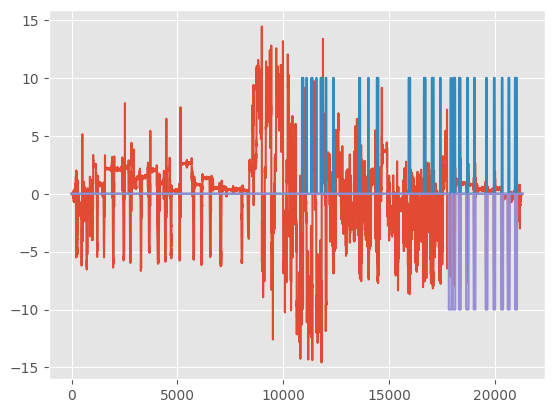

In [19]:
id = 3
session,y = load_one_session(data_dir, id)
test_dataset = load_one_windowed_session(data_dir, id, winsize=WINSIZE)
testloader = DataLoader(test_dataset, batch_size=10000)
y_true, y_pred, testloss = evaluate_loop(model, criterion, testloader, device)

y_pred = prepare_labels_for_plot(y_pred, WINSIZE)
y_true = prepare_labels_for_plot(y_true, WINSIZE)

plt.plot(session[:,0])
plt.plot(y_pred)
plt.plot(y_true*-1)

# Test Trained Models

In [81]:
# from smokingml.models import ResNetLSTM
from smokingml.datasets.nursing_dataset_v1.dataloading import load_one_windowed_session
import plotly.express as px
import pandas as pd
import numpy as np

# model = ResNetLSTM(winsize=WINSIZE).to(device)
# criterion = ResNetLSTM.get_criterion()
# optimizer = ResNetLSTM.get_optimizer(model)

# model.load_state_dict(torch.load('../nursingv1_projects/tests/lstm/5/best_model.pt'))

id = 4
session,y = load_one_session(data_dir, id)
dataset = load_one_windowed_session(data_dir, id, WINSIZE)
loader = DataLoader(dataset, batch_size=64)

y_true, y_pred, testloss = evaluate_loop(model, criterion, loader, device)

y_pred = prepare_labels_for_plot(y_pred, WINSIZE)
y_true = prepare_labels_for_plot(y_true, WINSIZE)



_,_,y_pred_expert = puff_state_machine(torch.from_numpy(y_pred / 10))

print(stats(torch.from_numpy(y_pred / 10)))
print(stats(torch.from_numpy(y_true / 10)))
print(stats(y_pred_expert))

df = pd.DataFrame(dict(
    x=session[:,0], 
    y=session[:,1], 
    z=session[:,2],
    y_true=y_true,
    y_pred=y_pred,
    y_pred_expert=y_pred_expert
))

fig = px.line(df, x=df.index, y=df.columns)
fig.show(renderer='browser')

Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 2.249
   puff count  average puff duration  total puff duration
0        83.0              47.578313               3949.0
   puff count  average puff duration  total puff duration
0        10.0                  134.0               1340.0
   puff count  average puff duration  total puff duration
0        36.0             114.416667               4119.0


In [70]:
def stats(y_pred):
    y_pred = y_pred.squeeze().long()
    current_state = y_pred[0].item()
    current_length = 1
    states = {
        0:[],
        1:[]
    }
    for epoch in y_pred[1:]:
        if epoch != current_state:
            states[current_state].append(current_length)
            current_state = epoch.item()
            current_length = 0
        current_length += 1
    states[current_state].append(current_length)
    puff_bouts = states[1]
    puff_count = len(puff_bouts)
    average_puff_duration = np.mean(puff_bouts)
    total_puff_duration = np.sum(puff_bouts)
    return pd.DataFrame([puff_count,average_puff_duration,total_puff_duration],index=['puff count','average puff duration','total puff duration']).T

def puff_state_machine(predictions):
    ret = predictions.clone()
    state = 0
    states = []
    puff_locations = []
    currentInterPuffIntervalLength = 0
    currentPuffLength = 0
    puff_start = 0
    for i,smokingOutput in enumerate(predictions):
        states.append(state)
        if (state == 0 and smokingOutput == 0.0):
            # no action
            state = 0
        elif (state == 0 and smokingOutput == 1.0):
            # starting validating puff length
            state = 1
            currentPuffLength += 1
            puff_start = i
        elif (state == 1 and smokingOutput == 1.0):
            # continuing not yet valid length puff
            currentPuffLength += 1
            if (currentPuffLength > 14) :
                # valid puff length!
                state = 2
        elif (state == 1 and smokingOutput == 0.0):
            # never was a puff, begin validating end
            state = 3
            currentInterPuffIntervalLength += 1
        elif (state == 2 and smokingOutput == 1.0):
            # continuing already valid puff
            currentPuffLength += 1
        elif (state == 2 and smokingOutput == 0.0):
            # ending already valid puff length
            state = 4 # begin validating inter puff interval
            currentInterPuffIntervalLength += 1
        elif (state == 3 and smokingOutput == 0.0): 
            currentInterPuffIntervalLength += 1
            if (currentInterPuffIntervalLength > 30):
                # valid interpuff
                state = 0
                currentPuffLength = 0
                currentInterPuffIntervalLength = 0
                ret[puff_start:i-30] = 0
        elif (state == 3 and smokingOutput == 1.0):
            # was validating interpuff for puff that wasn't valid
            currentPuffLength += 1
            currentInterPuffIntervalLength = 0
            if (currentPuffLength > 14) :
                # valid puff length!
                state = 2
            else:
                state = 1
        elif (state == 4 and smokingOutput == 0.0) :
            currentInterPuffIntervalLength += 1
            if (currentInterPuffIntervalLength > 30):
                # valid interpuff for valid puff
                state = 0
                currentPuffLength = 0
                currentInterPuffIntervalLength = 0
                puff_locations.append(i)
                ret[puff_start:i-30] = 1
        elif (state == 4 and smokingOutput == 1.0):
            # back into puff for already valid puff
            currentInterPuffIntervalLength = 0
            currentPuffLength += 1
            state = 2
    states = states[1:] + [0]
    return states,puff_locations,ret